## 功能
1. 加载地图，高亮坐标由 pandas 给出
2. sns.swarmplot
3. word cloud
4. line chart: 点，点之间连线，水平线 
5. heatmap
6. boxplot

In [30]:
%config InlineBackend.figure_format = 'retina'

# 代码自动完成提示 tab 键
%config IPCompleter.greedy=True

# 一个 cell 可以多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [31]:
#加载库
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas 
from urllib import request
import re
from shapely.geometry import LineString,Point
from urllib import parse
from urllib.request import urlopen
import hashlib
import json
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [74]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

sns.set_style("darkgrid",{"font.sans-serif":['Microsoft YaHei','Droid Sans Fallback']})

# 显示中文标签
plt.rc('font', family='SimHei', size=18)
sns.set()
%matplotlib inline


In [32]:
# 加载台风数据
data = pd.read_excel('./data/taifeng_tidy.xlsx')

# 转换成 datetime 格式
data['登陆时间'] = pd.to_datetime(data['登陆时间'], format='%Y年%m月%d日')

# 数据规格
data.shape
# 输出：(715, 7)

# 查看后10行
data.tail(5)

(715, 7)

,CMA编号,中文名称,英文名称,登陆地点,登陆时间,巅峰强度,登陆强度
710,1513,苏迪罗,Soudelor,台湾省花莲县秀林乡,2015-08-08,18级，68m/s，905hPa,14级，45m/s，950hPa
711,1513,苏迪罗,Soudelor,福建省莆田市秀屿区山亭镇,2015-08-08,18级，68m/s，905hPa,11级，30m/s，980hPa
712,1521,杜鹃,Dujuan,台湾省宜兰县南澳乡,2015-09-28,17级，58m/s，930hPa,15级，48m/s，945hPa
713,1521,杜鹃,Dujuan,福建省莆田市秀屿区山亭镇,2015-09-29,17级，58m/s，930hPa,11级，30m/s，982hPa
714,1522,彩虹,Mujigae,广东省湛江市坡头区南三镇,2015-10-04,16级，52m/s，935hPa,16级，52m/s，935hPa


In [33]:
def get_geoInfo(address):
    # 我们可以看到数据集里只有登陆地址，没有确切的经纬度信息 。
    # 这里需要通过地理编码的方式获取经纬度，使用的是高德地图API。
    # address = '广东省湛江市坡头区南三镇'

    # 本文城市变量为中文，为防止乱码，先用quote进行编码
    addr = parse.quote(address)

    ak = 'dcfb4c89564fe0418e858d613ed5258a'
    url = 'restapi.amap.com/v3/geocode/geo?key='
    url2 = 'http://restapi.amap.com/v3/geocode/geo?key={}&address={}'.format(
        ak, addr)

    # 打开 url，获取 response，是 string，需要 decode 成 json
    req = urlopen(url2)
    response = req.read().decode()

    #将返回的数据转化成json格式
    responseJson = json.loads(response)

    firstNode = responseJson.get('geocodes')[0]
    coor = firstNode['location'].split(',')

    rtn = (coor[0], coor[1], firstNode['province'], firstNode['city'],
           firstNode['district'])
    return rtn


# test
rtn = get_geoInfo('广东省湛江市坡头区南三镇')
rtn

('110.552974', '21.150907', '广东省', '湛江市', '坡头区')

In [34]:
# 添加经、纬度字段
data['coor'] = data['登陆地点'].apply(lambda x: get_geoInfo(x))


In [57]:
data['longitude'] = data['coor'].apply(lambda x: float(x[0]))
data['latitude'] = data['coor'].apply(lambda x: float(x[1]))
data['省'] = data['coor'].apply(lambda x:x[2])
data['市'] = data['coor'].apply(lambda x:x[3])
data['区县'] = data['coor'].apply(lambda x:x[4])

Text(0.5, 1, '1945-2015 全国沿海省份台风登陆地点分布图')

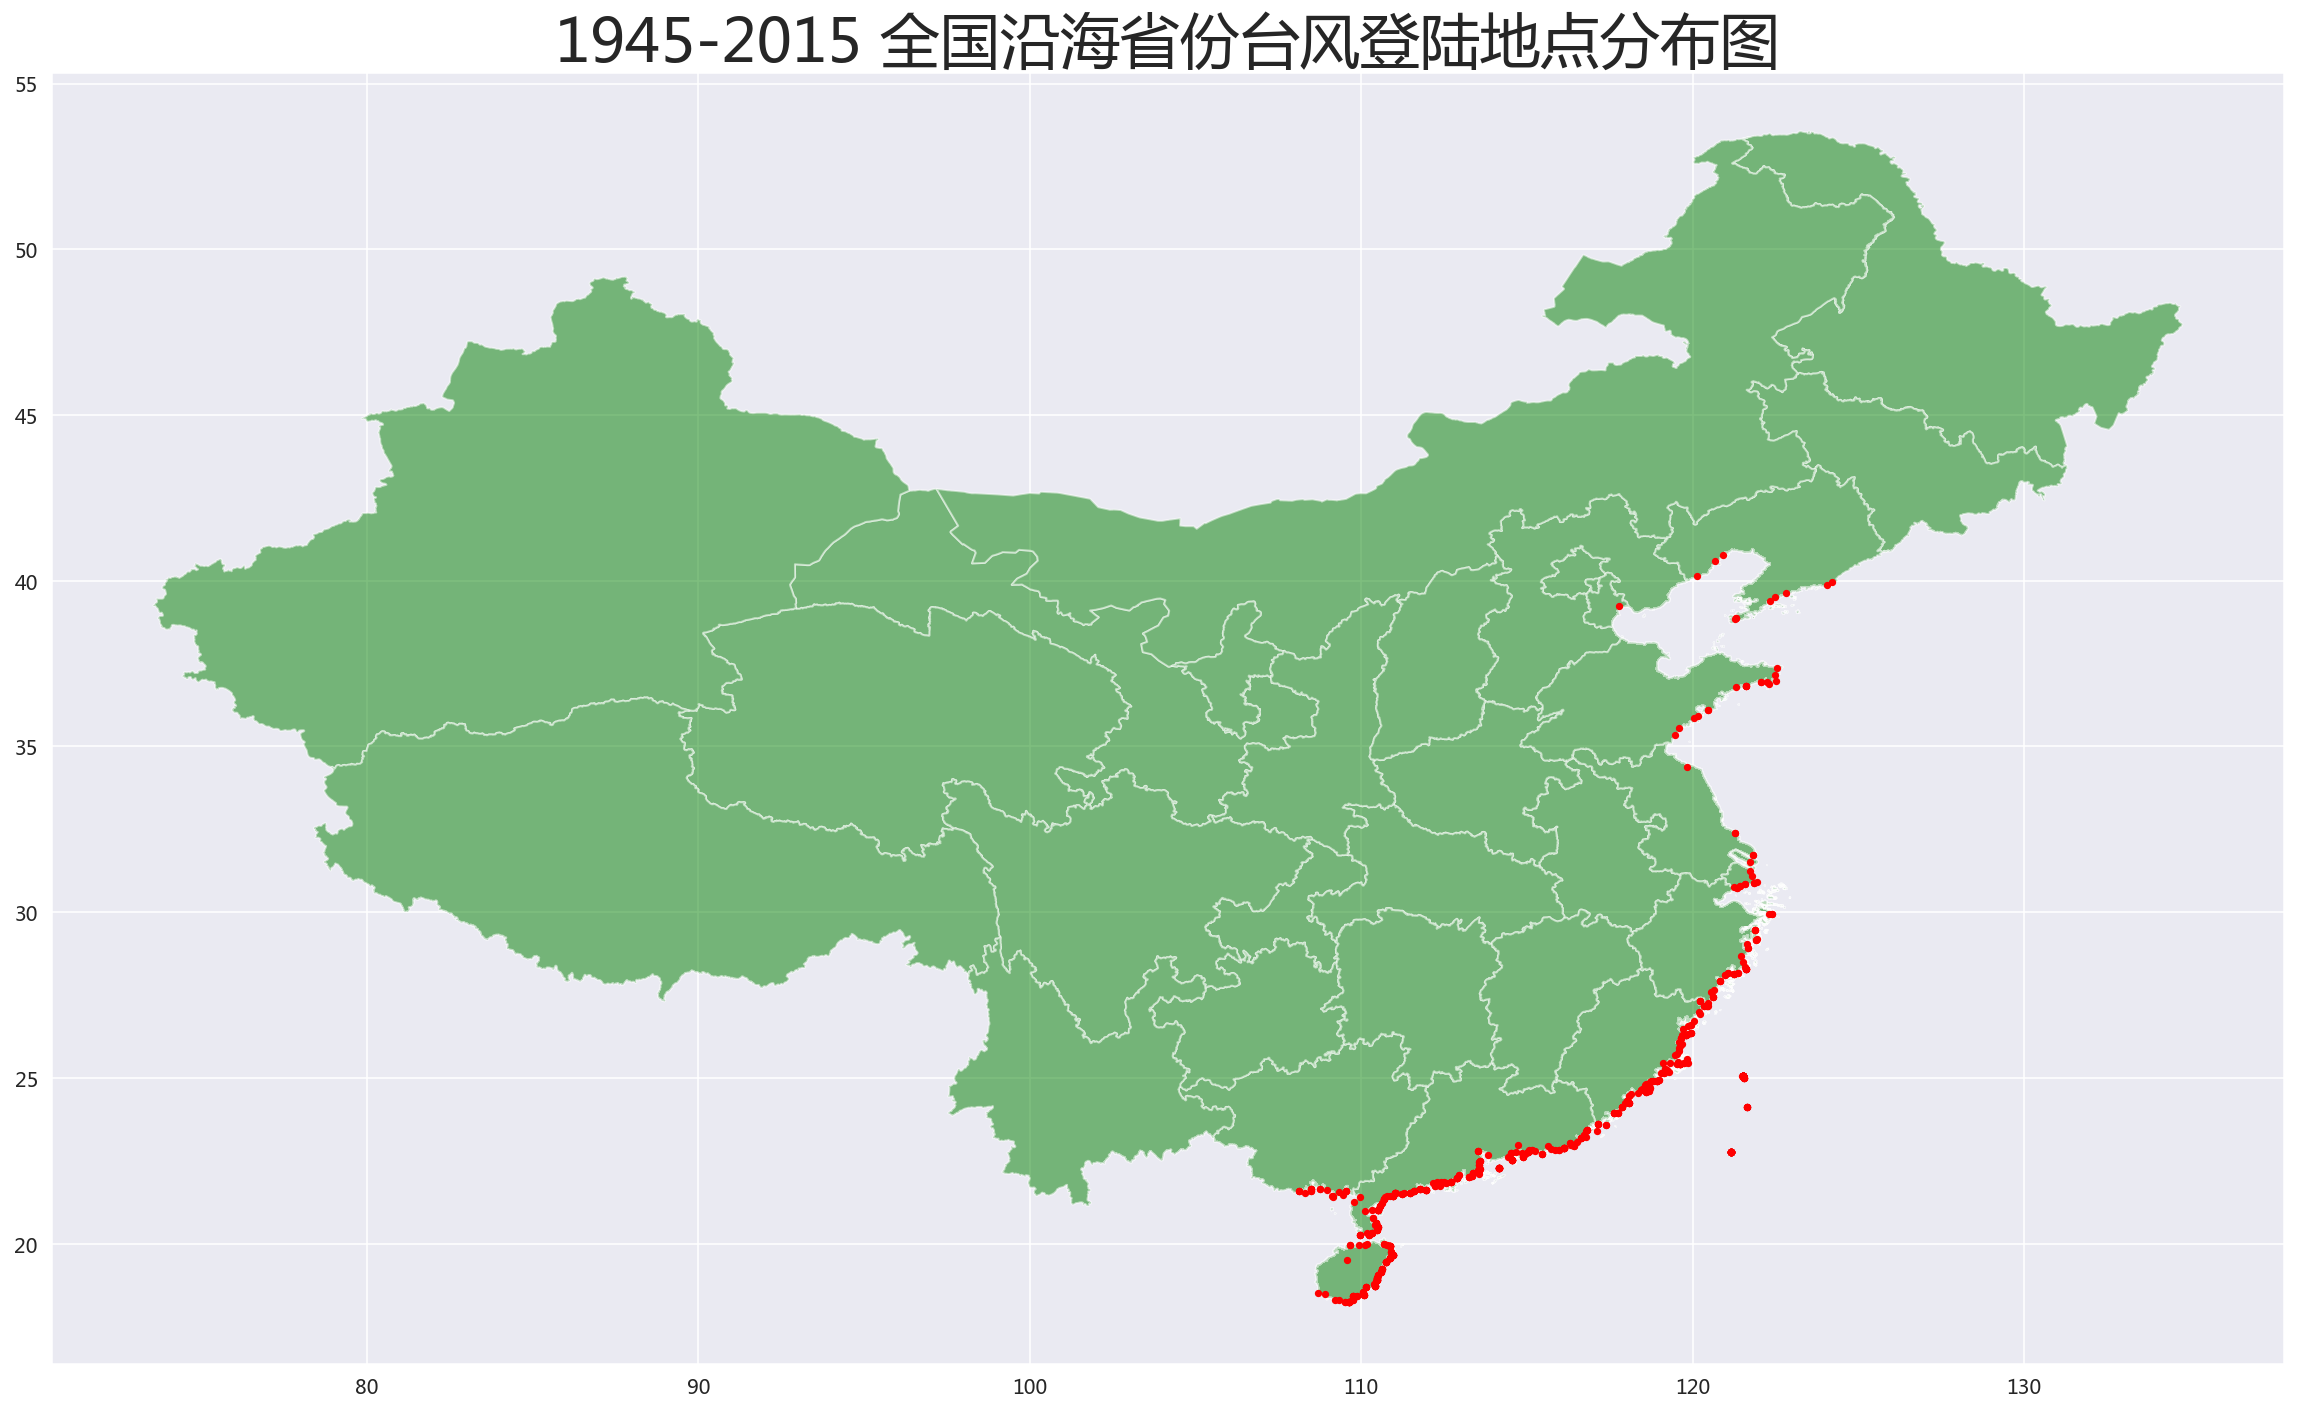

In [58]:
# https://gadm.org/download_country_v3.html

# 读取已经下载好的中国地图shapefile格式底图
gdf = geopandas.read_file("../dataset/geo/gadm36_CHN_shp/gadm36_CHN_1.shp")
# 展示中国地图
ax = gdf.plot(figsize=(20, 20),
              alpha=0.5,
              edgecolor='white',
              color='g',
              linewidth=1)

# 在中国地图底图上展示台风登陆点
# 将data数据读取为GeoDataFrame格式，这是geopandas库用于地理空间可视化的专有数据格式
geo_data = geopandas.GeoDataFrame(data,
                                  geometry=geopandas.points_from_xy(
                                      data.longitude, data.latitude))

geo_data.plot(ax=ax, color='red', markersize=7)

# plt.rc('font', family='Microsoft YaHei', size=18)
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

plt.title('1945-2015 全国沿海省份台风登陆地点分布图', size=30)
plt.show()

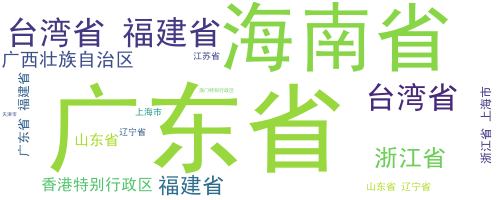

In [36]:
# 词云展示 台风登陆的省份分布
words = ','.join(data['省'].values.tolist())
wc = WordCloud(
    background_color="white",  #背景颜色
    max_words=300,  #显示最大词数
    font_path='./fonts/simhei.ttf',  #显示中文
    min_font_size=5,
    max_font_size=100,
    width=500  #图幅宽度
)
x = wc.generate(words)
image = x.to_image()
image

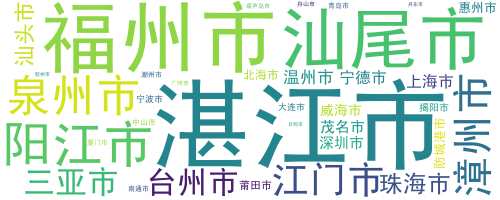

In [37]:
# 词云展示 台风登陆的城市分布
# words = ','.join(data['市'].values.tolist())
# 台湾 城市 有 [] 的记录
d = filter(lambda x: type(x) == str, data['市'].values)
words = ','.join(d)

wc = WordCloud(
    background_color="white",  #背景颜色
    max_words=300,  #显示最大词数
    font_path='./fonts/simhei.ttf',  #显示中文
    min_font_size=5,
    max_font_size=100,
    width=500  #图幅宽度
)
x = wc.generate(words)
image = x.to_image()
image

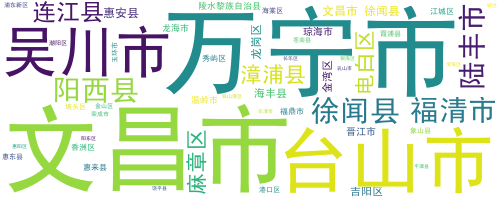

In [38]:
# 词云展示 台风登陆的区县分布
# words = ','.join(data['区县'].values.tolist())
d = filter(lambda x: type(x) == str, data['区县'].values)
words = ','.join(d)

wc = WordCloud(
    background_color="white", #背景颜色
    max_words=300, #显示最大词数
    font_path='./fonts/simhei.ttf',#显示中文
    min_font_size=5,
    max_font_size=100,
    width=500  #图幅宽度
    )
x = wc.generate(words)
image = x.to_image()
image

In [137]:
data.columns

Index(['CMA编号', '中文名称', '英文名称', '登陆地点', '登录时间', '巅峰强度', '登陆强度', 'coor', 'lat',
       'lon', '省', '市', '区县'],
      dtype='object')

In [39]:
# 新建data_1
# data_1 = data[['登陆时间', '登陆强度', '巅峰强度', '省']].dropna()

cols = ['CMA编号', '登陆时间', '登陆强度', '巅峰强度', '省']
data_1 = pd.DataFrame(data, columns = cols) 

# 转成时间
# data_1['登陆时间'] = pd.to_datetime(data_1['登陆时间'])

data_1['登陆等级'] = data_1['登陆强度'].apply(
    lambda x: int(re.match('\d+',
                           str(x).split('，')[0]).group()))
data_1['巅峰等级'] = data_1['巅峰强度'].apply(
    lambda x: int(re.match('\d+',
                           str(x).split('，')[0]).group()))
data_1['登陆年份'] = data_1['登陆时间'].apply(lambda x: x.year)
data_1['登陆月份'] = data_1['登陆时间'].apply(lambda x: x.month)

data_1[:5]

,CMA编号,登陆时间,登陆强度,巅峰强度,省,登陆等级,巅峰等级,登陆年份,登陆月份
0,4505,1945-07-07,8级，20m/s，994hPa,10级，25m/s，985hPa,广东省,8,10,1945,7
1,4510,1945-08-10,8级，20m/s，994hPa,13级，41m/s，960hPa,广东省,8,13,1945,8
2,4515,1945-08-25,12级，35m/s，970hPa,12级，35m/s，970hPa,广东省,12,12,1945,8
3,4516,1945-09-02,14级，42m/s，955hPa,16级，53m/s，940hPa,台湾省,14,16,1945,9
4,4516,1945-09-03,10级，25m/s，985hPa,16级，53m/s，940hPa,福建省,10,16,1945,9


In [ ]:
# 多条件查看数据
data_1.loc[ (data_1['省'] == '浙江省') & (data_1['登陆等级'] > 20)]

<Figure size 1296x432 with 0 Axes>

Text(0.5, 1.0, '1945-2015 各省台风登陆等级分类散点图（点数多少代表台风数量）')

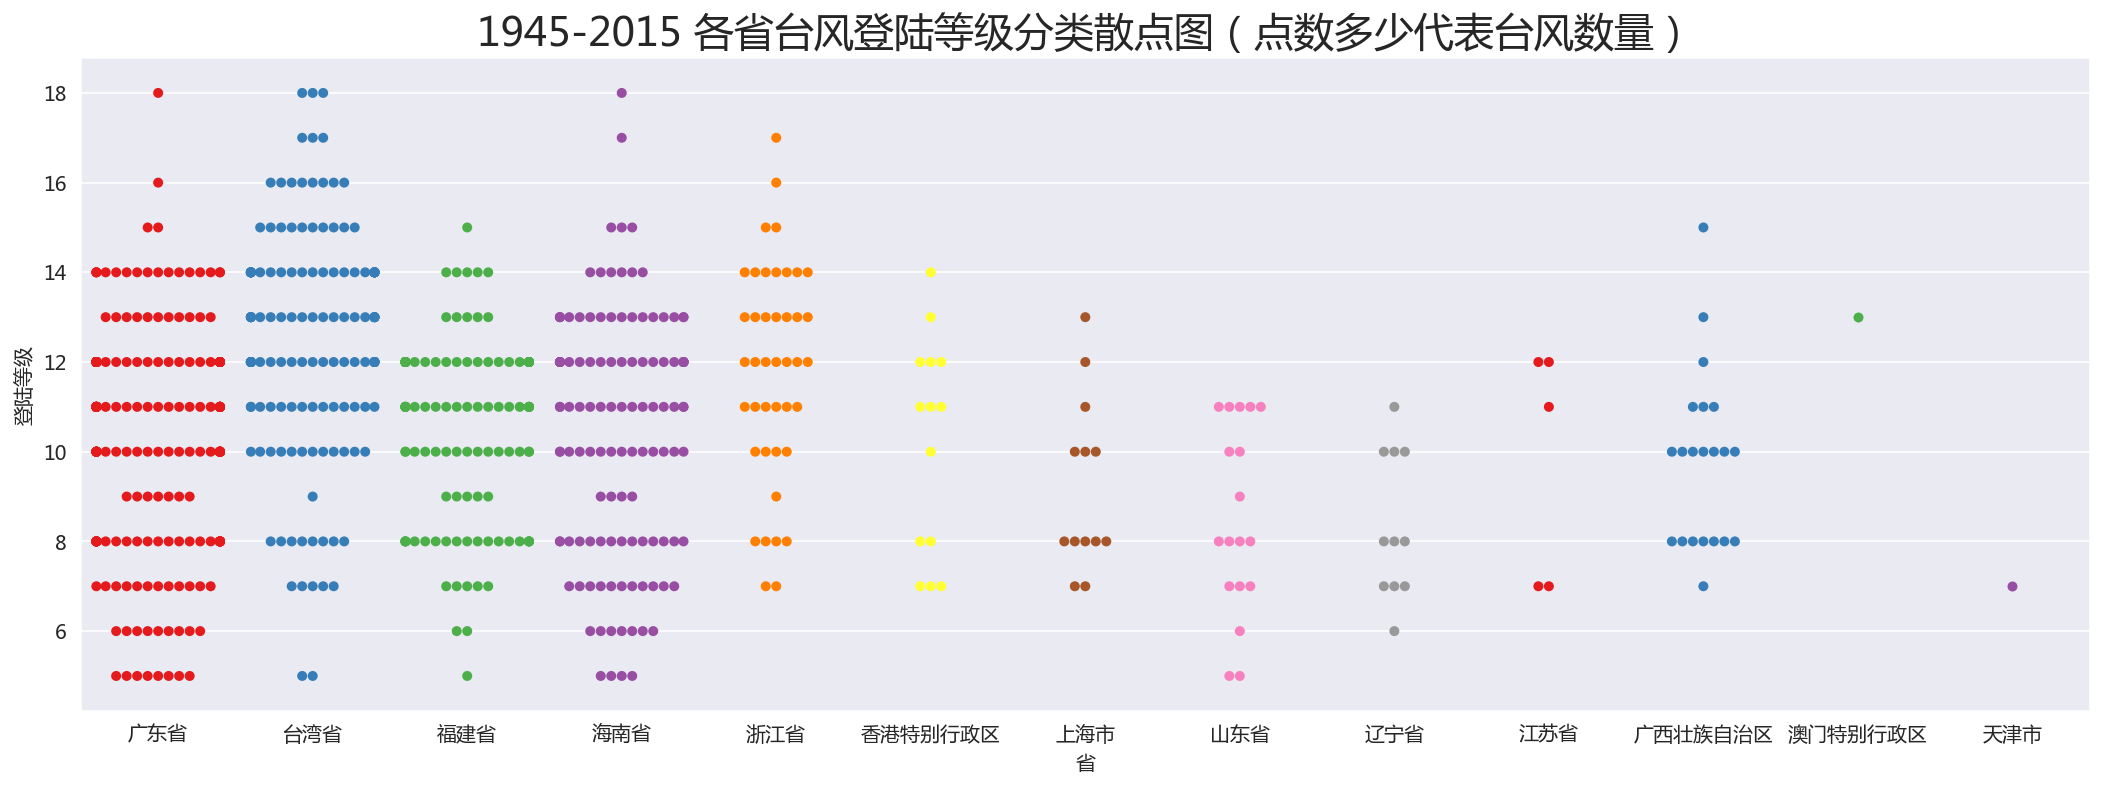

In [53]:
# 数据中有错误，限制一下
data_1 = data_1.loc[data_1['登陆等级'] <= 20]

# 各省台风等级分类散点图
plt.figure(figsize=(18, 6))
sns.swarmplot(x='省', y='登陆等级', data=data_1, palette='Set1')
plt.title("1945-2015 各省台风登陆等级分类散点图（点数多少代表台风数量）", size=20)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set_style("darkgrid",{"font.sans-serif":['Microsoft YaHei','Droid Sans Fallback']})

plt.show()

<Figure size 1080x432 with 0 Axes>

Text(0.5, 0, '年份')

Text(0, 0.5, '次数')

Text(0.5, 1.0, '1945-2015 全国每年台风登陆数量')

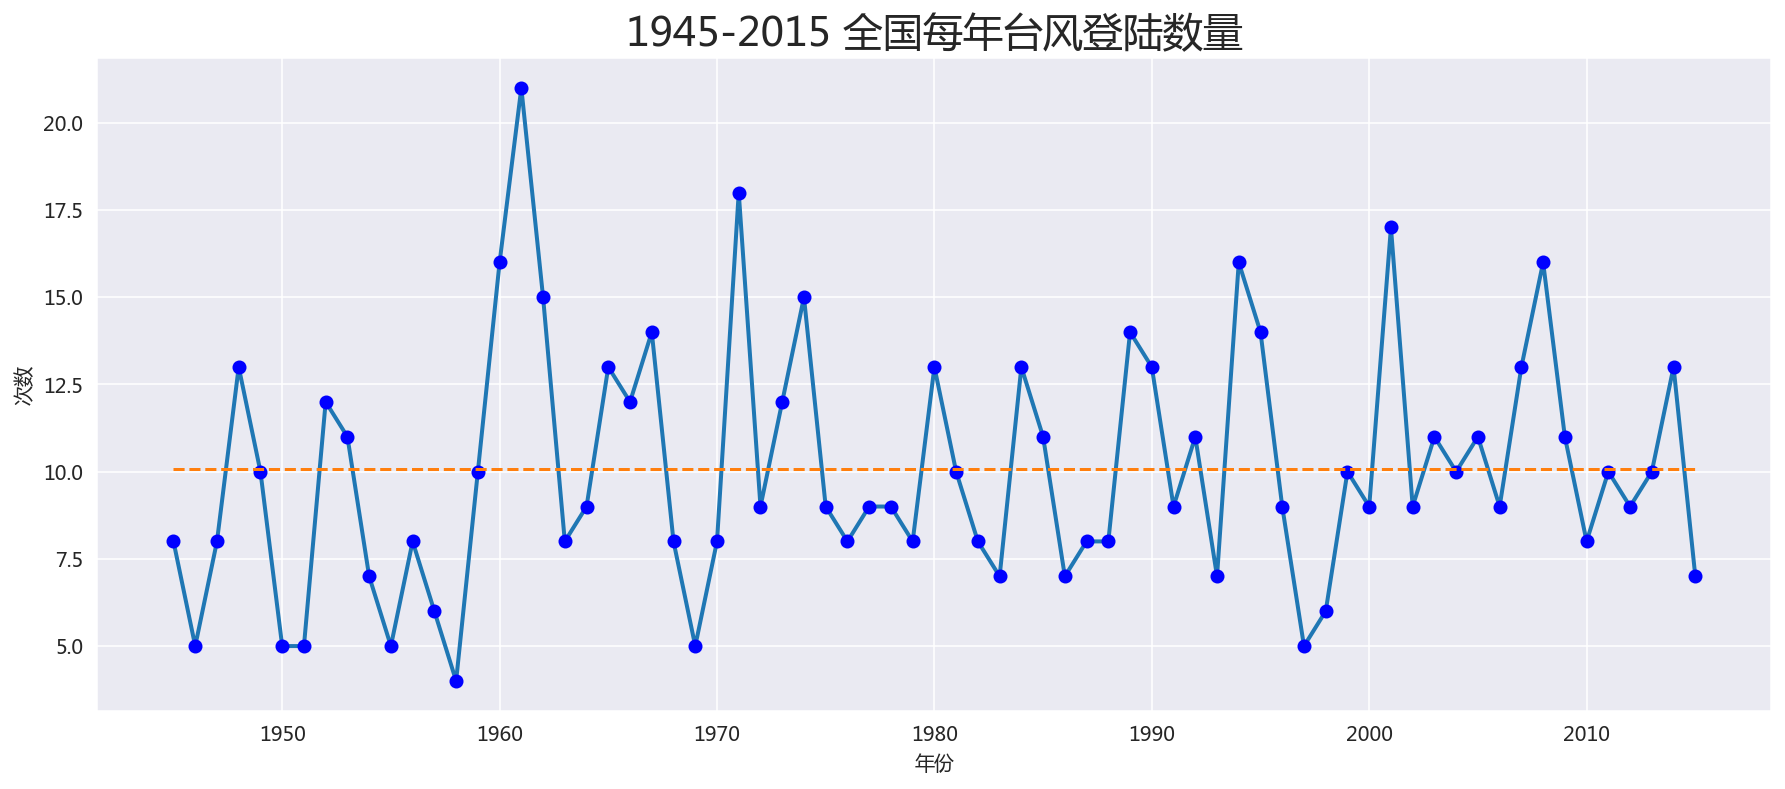

In [52]:
# 每年台风数量
year_counts = data['登陆时间'].apply(lambda x: x.year).value_counts().sort_index()
plt.figure(figsize=(15, 6))
plt.plot(year_counts, lw=2)
plt.plot(year_counts, 'ro', color='b')
x = year_counts.index.tolist()
y_mean = [year_counts.mean()] * year_counts.shape[0]
plt.plot(x, y_mean, '--')
plt.xlabel('年份')
plt.ylabel('次数')

plt.title('1945-2015 全国每年台风登陆数量', size=20)

# plt.rc('font', family='SimHei', size=18)
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set_style("darkgrid",{"font.sans-serif":['Microsoft YaHei','Droid Sans Fallback']})

plt.show()

<Figure size 576x432 with 0 Axes>

Text(0.5, 1, '1945-2015 全国台风登陆次数热力图（按月份-登陆等级）')

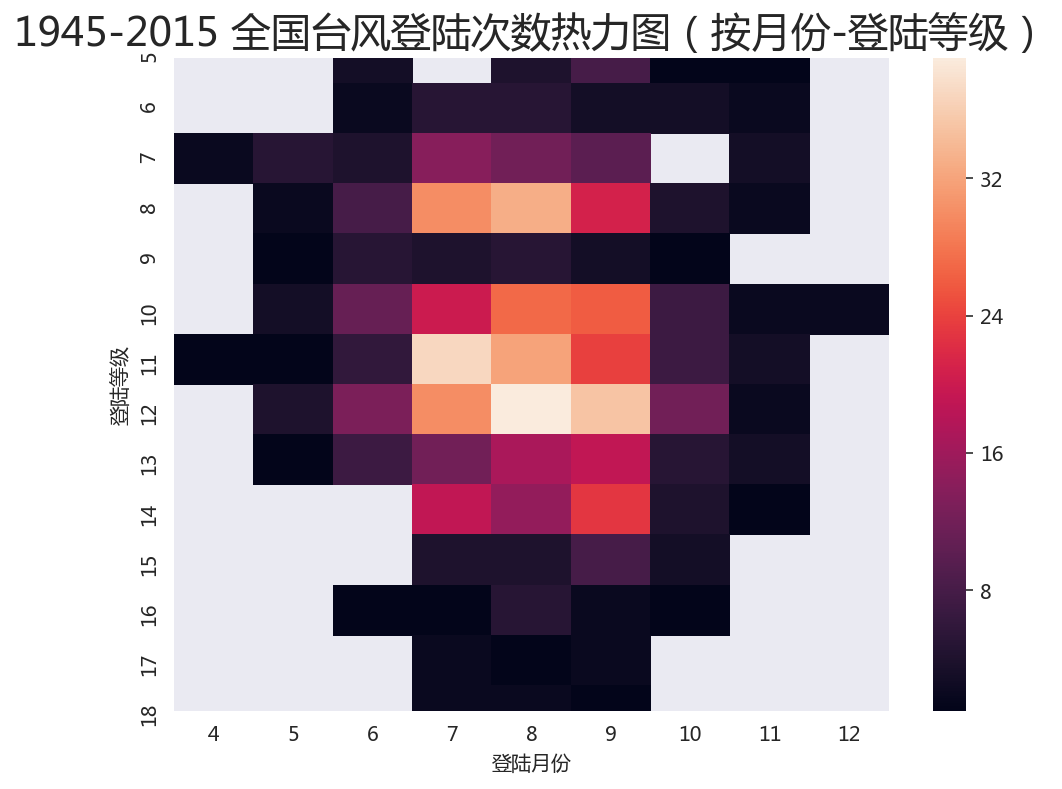

In [51]:
# 不同月份台风登陆时的强度等级
data_3 = data_1.groupby(['登陆月份', '登陆等级'], as_index=False)['登陆时间'].count()
data_3 = data_3.rename(columns={'登陆时间': '登录次数'})
# data_2.sort_values(['登陆等级','登陆月份'])
data_3_pivot = data_3.pivot('登陆等级', '登陆月份', '登录次数')
# data_2_pivot
plt.figure(figsize=(8, 6))
sns.heatmap(data_3_pivot)
plt.title('1945-2015 全国台风登陆次数热力图（按月份-登陆等级）', size=20)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set_style("darkgrid",{"font.sans-serif":['Microsoft YaHei','Droid Sans Fallback']})

plt.show()

In [22]:
data_1[:5]

,CMA编号,登陆时间,登陆强度,巅峰强度,省,登陆等级,巅峰等级,登陆年份,登陆月份
0,4505,NaT,8级，20m/s，994hPa,10级，25m/s，985hPa,NaN,8,10,NaN,NaN
1,4510,NaT,8级，20m/s，994hPa,13级，41m/s，960hPa,NaN,8,13,NaN,NaN
2,4515,NaT,12级，35m/s，970hPa,12级，35m/s，970hPa,NaN,12,12,NaN,NaN
3,4516,NaT,14级，42m/s，955hPa,16级，53m/s，940hPa,NaN,14,16,NaN,NaN
4,4516,NaT,10级，25m/s，985hPa,16级，53m/s，940hPa,NaN,10,16,NaN,NaN


<Figure size 576x432 with 0 Axes>

Text(0.5, 1.0, '1945-2015 全国台风登陆等级分布箱图')

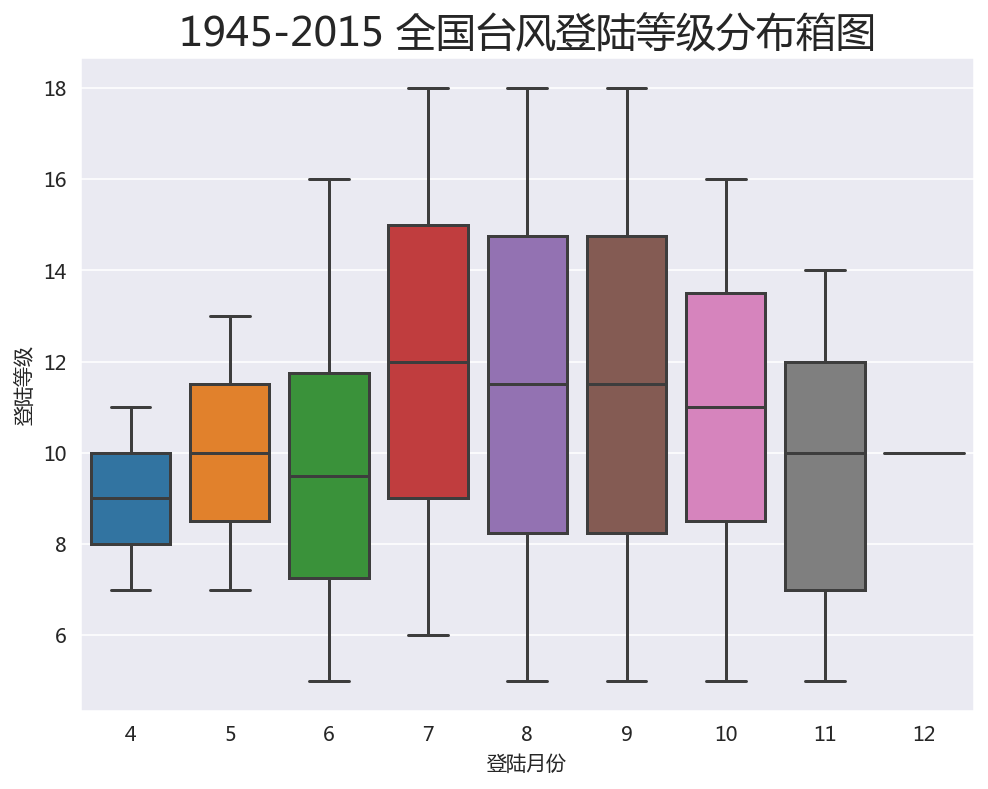

In [50]:
# 台风登陆等级箱图，看看每个月的台风强度变化

plt.figure(figsize=(8, 6))
sns.boxplot(x='登陆月份', y='登陆等级', data=data_3)
plt.title('1945-2015 全国台风登陆等级分布箱图', size=20)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set_style("darkgrid",{"font.sans-serif":['Microsoft YaHei','Droid Sans Fallback']})

plt.show()

<Figure size 576x432 with 0 Axes>

Text(0.5, 1, '1945-2015 全国台风登陆次数热力图（按月份-巅峰等级）')

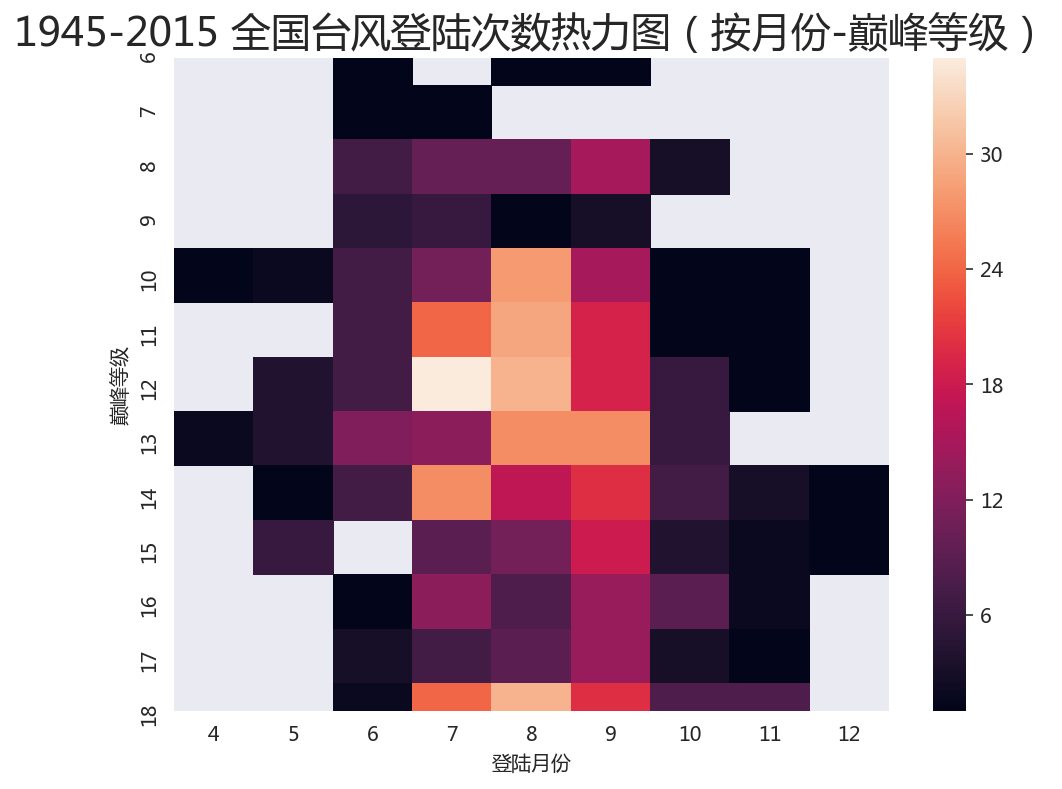

In [49]:
# 台风登陆次数热力图，横坐标代表登陆月份，纵坐标代表巅峰等级，颜色代表登录次数
# 不同月份台风登陆时的强度等级
data_2 = data_1.groupby(['登陆月份', '巅峰等级'], as_index=False)['登陆时间'].count()
data_2 = data_2.rename(columns={'登陆时间': '登录次数'})
data_2_pivot = data_2.pivot('巅峰等级', '登陆月份', '登录次数')
plt.figure(figsize=(8, 6))
sns.heatmap(data_2_pivot)
plt.title('1945-2015 全国台风登陆次数热力图（按月份-巅峰等级）', size=20)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set_style("darkgrid",{"font.sans-serif":['Microsoft YaHei','Droid Sans Fallback']})

plt.show()

<Figure size 576x432 with 0 Axes>

Text(0.5, 1.0, '1945-2015 全国台风巅峰等级箱图')

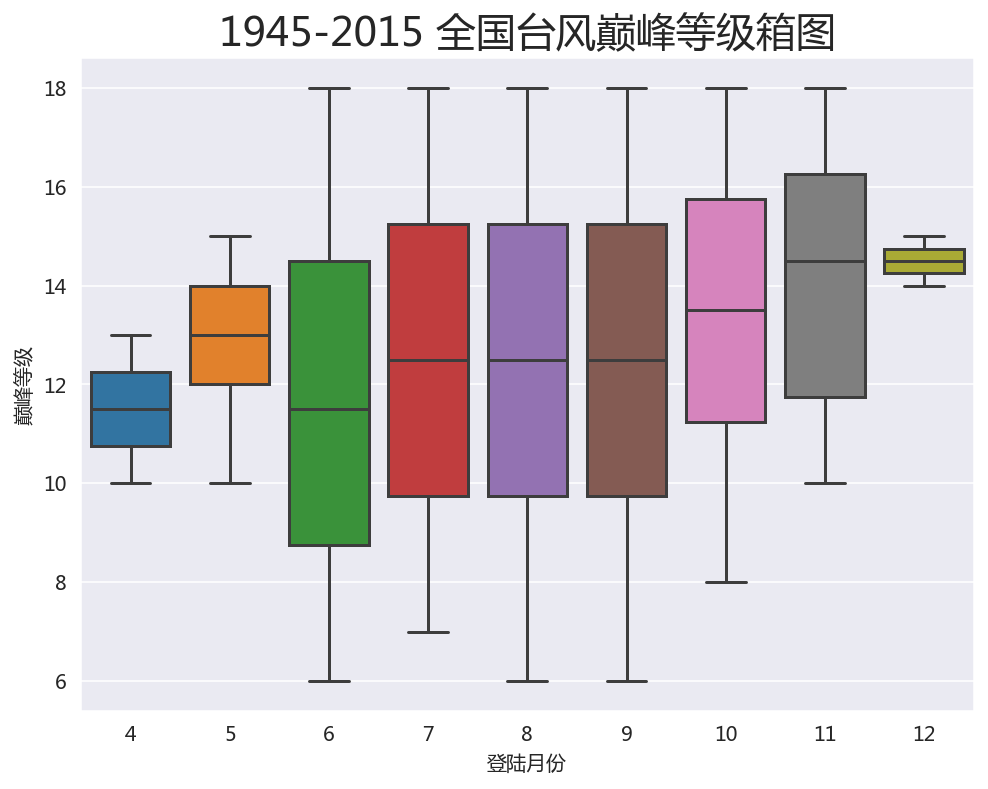

In [48]:
# 台风巅峰等级箱图，看看每个月的台风强度变化

plt.figure(figsize=(8, 6))

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set_style("darkgrid",{"font.sans-serif":['Microsoft YaHei','Droid Sans Fallback']})

sns.boxplot(x='登陆月份', y='巅峰等级', data=data_2)
plt.title('1945-2015 全国台风巅峰等级箱图', size=20)

plt.show()